In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# 1. 数据预处理和加载
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# 2. 定义模型
class ResNet50CIFAR100(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet50CIFAR100, self).__init__()
        self.model = resnet50(pretrained=False)
        self.model.fc = nn.Linear(2048, num_classes)  # 替换最后的全连接层以适应CIFAR-100

    def forward(self, x):
        return self.model(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet50CIFAR100().to(device)

# 3. 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

Files already downloaded and verified
Files already downloaded and verified


c:\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
def train_and_evaluate(model, trainloader, testloader, num_epochs=100):

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
        scheduler.step()
     # 绘制损失和准确度曲线
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # 绘制训练损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练和测试准确度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Training and Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Epoch [1/100], Loss: 5.6098, Train Accuracy: 1.62%, Test Accuracy: 2.45%
Epoch [2/100], Loss: 4.2960, Train Accuracy: 3.68%, Test Accuracy: 5.52%
Epoch [3/100], Loss: 4.0399, Train Accuracy: 6.61%, Test Accuracy: 9.06%
Epoch [4/100], Loss: 3.8361, Train Accuracy: 9.63%, Test Accuracy: 11.96%
Epoch [5/100], Loss: 3.6540, Train Accuracy: 12.78%, Test Accuracy: 15.05%
Epoch [6/100], Loss: 3.4604, Train Accuracy: 16.23%, Test Accuracy: 17.99%
Epoch [7/100], Loss: 3.2929, Train Accuracy: 19.32%, Test Accuracy: 21.74%
Epoch [8/100], Loss: 3.1688, Train Accuracy: 21.52%, Test Accuracy: 18.78%
Epoch [9/100], Loss: 3.0635, Train Accuracy: 23.45%, Test Accuracy: 26.47%
Epoch [10/100], Loss: 2.9662, Train Accuracy: 25.48%, Test Accuracy: 25.46%
Epoch [11/100], Loss: 2.8560, Train Accuracy: 27.75%, Test Accuracy: 27.31%
Epoch [12/100], Loss: 2.7847, Train Accuracy: 29.06%, Test Accuracy: 31.01%
Epoch [13/100], Loss: 2.7066, Train Accuracy: 30.58%, Test Accuracy: 28.04%
Epoch [14/100], Loss: 2.6345

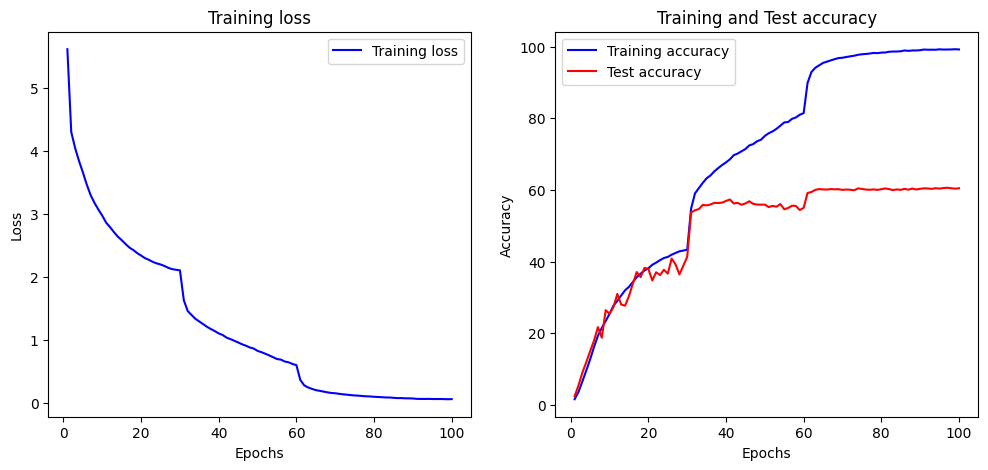

In [3]:
train_and_evaluate(model, trainloader, testloader, num_epochs=100)

In [4]:
torch.save(model,'resnet50.pth')